In [1]:
import pycigar
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
from pycigar.utils.logging import logger
from pycigar.utils.output import plot_new

from ray.tune.registry import register_env

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import json
from pathlib import Path
from ray.rllib.models.tf.tf_action_dist import DiagGaussian
from ray.rllib.models.catalog import ModelCatalog
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## Env config

In [2]:
pycigar_params = {'exp_tag': 'cooperative_multiagent_ppo',
                  'env_name': f'CentralControlPhaseSpecificContinuousPVInverterEnv',
                  'simulator': 'opendss'}
create_env, env_name = make_create_env(pycigar_params, version=0)
register_env(env_name, create_env)

misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/misc_inputs.csv"
dss_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/ieee37.dss"
load_solar_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/load_solar_data.csv"
breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/breakpoints.csv"
sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path)


In [3]:
eval_start = 100
sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]
sim_params['scenario_config']['multi_config'] = False
del sim_params['attack_randomization']

for node in sim_params['scenario_config']['nodes']:
    for d in node['devices']:
        d['adversary_controller'] = 'unbalanced_fixed_controller'
        name = d['name']
        c = np.array(d['custom_configs']['default_control_setting'])
        if name.endswith('a'):
            c = c - 0.02
        elif name.endswith('b'):
            c = c + 0.02
        elif name.endswith('c'):
            c = c - 0.01
        d['custom_configs']['default_control_setting'] = c


## Util: eval policy checkpoint

In [4]:
def eval_dir(best_dir, eval_start=100):
    result_dict = {'stds': [], 'dir': best_dir.parent}
    params = json.loads((best_dir.parent / 'params.json').read_text())['config']['evaluation_config']['env_config']
    params['scenario_config'] = sim_params['scenario_config']
    sim_params['M'] = params['M']
    sim_params['N'] = params['N']
    sim_params['P'] = params['P']
    
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]

    infos = json.loads((best_dir / 'info.json').read_text())
    result_dict['epoch'] = infos['epoch']

    policy = tf.saved_model.load(str(best_dir / f'policy_{infos["epoch"]}'))
    infer = policy.signatures['serving_default']

    test_env = create_env(sim_params)
    action_dist, _ = ModelCatalog.get_action_dist(
        test_env.action_space, config={}, dist_type=None, framework='tf')
    assert isinstance(action_dist, DiagGaussian.__class__), 'For now only continuous gaussian action are supported'

    done = False
    obs = test_env.reset()
    obs = obs.tolist()
    while not done:
        out = infer(
            prev_reward=tf.constant([0.], tf.float32),
            observations=tf.constant([obs], tf.float32),
            is_training=tf.constant(False),
            seq_lens=tf.constant([0], tf.int32),
            prev_action=tf.constant([0], tf.float32)
        )['behaviour_logits'].numpy()
        dist = action_dist(inputs=out, model=None)
        act, std = dist.deterministic_sample().numpy().flatten(), dist.std.numpy().flatten()
        result_dict['stds'].append(std)

        obs, r, done, _ = test_env.step(act)
        obs = obs.tolist()

    Logger = logger()
    f = plot_new(Logger.log_dict, Logger.custom_metrics, infos['epoch'], unbalance=True)
    result_dict['figure'] = f
    inv = [k for k in Logger.log_dict if k.startswith('inverter_s701') or k.startswith('inverter_s728')][0]

    result_dict['u_sum'] = sum(Logger.log_dict[inv]['u'])
    return result_dict

## Continuous gridearch

In [5]:
%matplotlib agg
%matplotlib agg

SAVE_PATH = '~/dev/LBL/lrc/results_continuous/'
results = []
for best_dir in Path(SAVE_PATH).expanduser().rglob('best/'):
    print(f'Evaluating {best_dir.parent}')
    result_dict = eval_dir(best_dir);
    results.append(result_dict)


Evaluating /home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_0_M=100,M=100,N=50,P=100_2020-06-24_11-13-094orucdy_
Evaluating /home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_0_M=1000,M=1000,N=50,P=100_2020-06-23_08-35-33sqg4e1f9
Evaluating /home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_0_M=50000,M=50000,N=50,P=100_2020-06-22_19-27-43lo2n359m
Evaluating /home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_1_M=100000,M=100000,N=50,P=100_2020-06-22_19-27-44t1ofp49z
Evaluating /home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_1_M=200,M=200,N=50,P=100_2020-06-24_11-13-11x5x5gh34
Evaluating /home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_1_M=5000,M=5000,N=50,P=100_2020-06-23_08-35-350xueuggd
Evaluating /home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_2_M=20000,M=20000,N=50,P=100_2020-06-23_08-35-35d_n410h9
Evaluating /home/alexandre/dev

In [6]:
print([d['u_sum'] for d in results])
print(np.argmin([d['u_sum'] for d in results]))
results[np.argmin([d['u_sum'] for d in results])]['dir']

[10.72286354885896, 7.207891114365516, 7.606113056835442, 7.818349569744158, 10.444597422717358, 7.764160654365292, 8.189170511894947, 8.467519915961594, 8.910111346363877]
1


PosixPath('/home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_0_M=1000,M=1000,N=50,P=100_2020-06-23_08-35-33sqg4e1f9')

## Continuous eval of best policy

In [7]:
%matplotlib agg
%matplotlib agg

best_dir = results[np.argmin([d['u_sum'] for d in results])]['dir'] / 'best/'
best_dir = Path('/home/alexandre/dev/LBL/lrc/results_continuous/main/run_train/run_train_0_M=1000,M=1000,N=50,P=100_2020-06-23_08-35-33sqg4e1f9/best')
continuous_u = []
continuous_results = []
for eval_start in tqdm(range(0, 14000, 1800)):
    result = eval_dir(best_dir, eval_start)
    continuous_u.append(result['u_sum'])
    continuous_results.append(result)


100%|██████████| 8/8 [01:16<00:00,  9.57s/it]


Text(0, 0.5, 'unbalance')

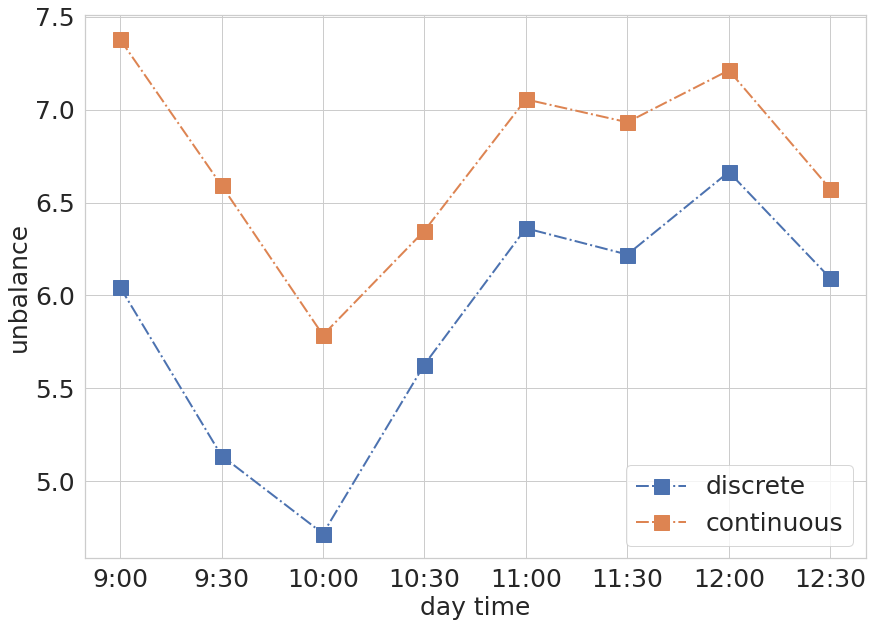

In [8]:
%matplotlib inline
import pandas as pd

times_index_str = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30']
discrete_u = [6.0444, 5.1379, 4.7188, 5.6285, 6.3616, 6.2202, 6.6645, 6.0929]

f, ax = plt.subplots(figsize=(14,10))
plt.plot(times_index_str, discrete_u, marker='s', lw=2, ls='-.', markersize=15, label='discrete')
plt.plot(times_index_str, continuous_u, marker='s', lw=2, ls='-.', markersize=15, label='continuous')

plt.legend(prop={'size': 25})
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('day time', fontsize=25)
plt.ylabel('unbalance', fontsize=25)
